# Alzheimer’s Disease Prediction by Machine Learning Models with MRI Images

### Importing Libraries

In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
import sys, glob, time,re,string
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0

### Loading The Dataset

### Dataset Analysis

In [2]:
#Dataset directory
dataset_dir = "./Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


As we can see there are four groups of images in the dataset such as 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented' and 'Non_Demented'.

In [3]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


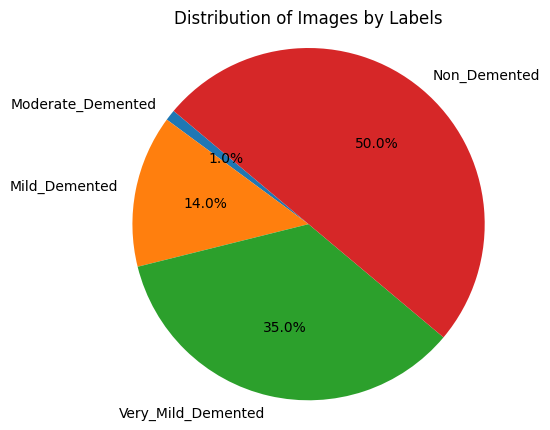

In [4]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [5]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

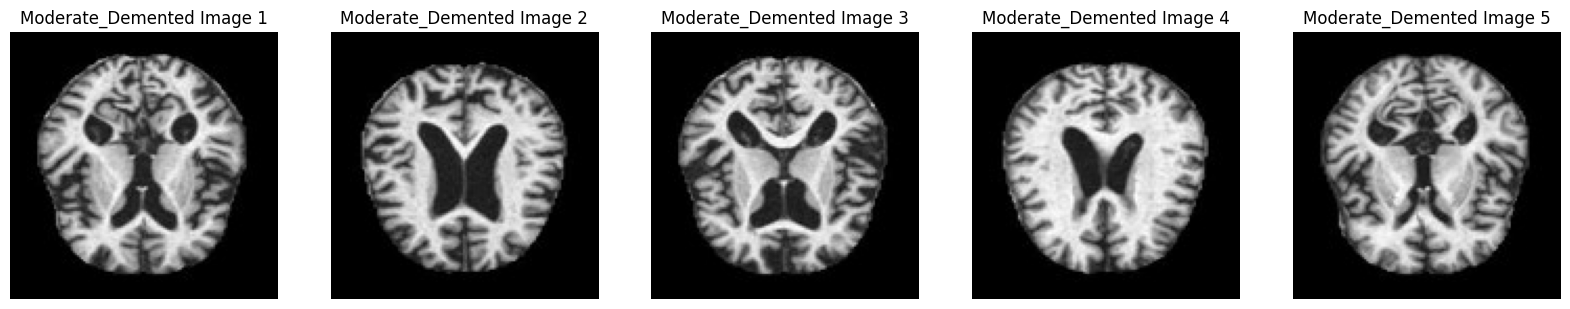

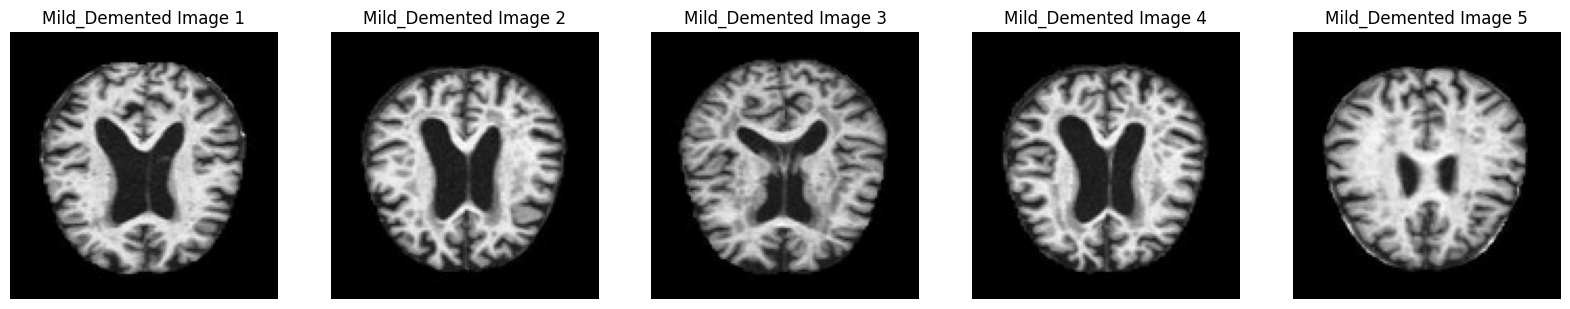

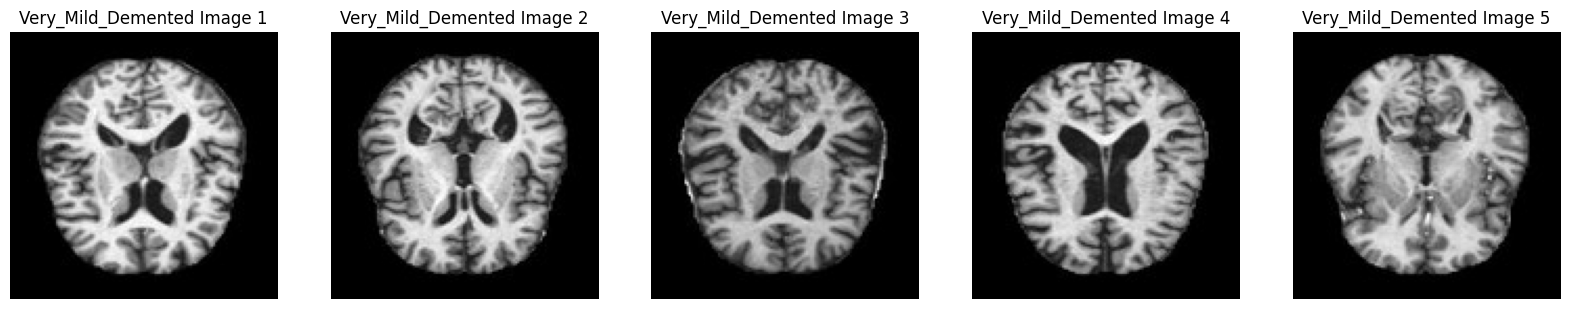

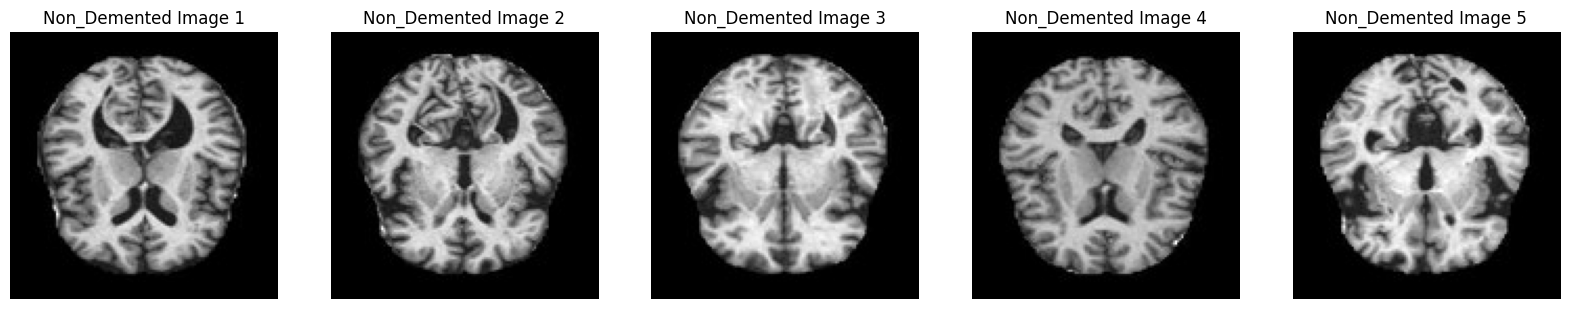

In [6]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

#### Resize

Each image in the dataset needs to have the same size—that is, 128 × 128. Even though the images that were chosen randomly have the same size, it is still important to review the data set and make any modifications that are required.

In [7]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [8]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Mild_Demented.
None of the images needed to be resized in Very_Mild_Demented.
None of the images needed to be resized in Non_Demented.


### Data Augmentation

There is a significant imbalance in the data set, as we have already analysed.  A greater number of images have been included in some labels than others. It has been decided to use the Generative Model to perform augmentation to prevent any potential problems that this situation might cause. 

#### DCGAN

In [9]:
#parameters
img_width, img_height = 128, 128
batch_size=32
latent_dim = 128
epochs = 60

In [10]:
#directories
img_generator = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)
#Main Data
dataset = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    class_mode='categorical'
)
#Moderate Data
moderate_demented = img_generator.flow_from_directory(
    dataset_dir,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    classes=['Moderate_Demented']
)

Found 6400 images belonging to 4 classes.
Found 64 images belonging to 1 classes.


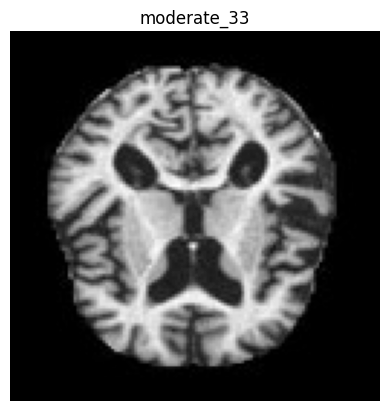

In [11]:
#Display random image from 'Moderate_Demented' class
moderate_dataset = os.path.join(dataset_dir, 'Moderate_Demented')
moderate_images = os.listdir(moderate_dataset)

img_name = np.random.choice(moderate_images)
img_path = os.path.join(moderate_dataset, img_name)

img = plt.imread(img_path)
img_name = os.path.splitext(img_name)[0]

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(img_name)
plt.show()

Found 6400 files belonging to 4 classes.


2024-10-26 17:53:33.102673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2024-10-26 17:53:33.102858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]
2024-10-26 17:53:33.136152: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


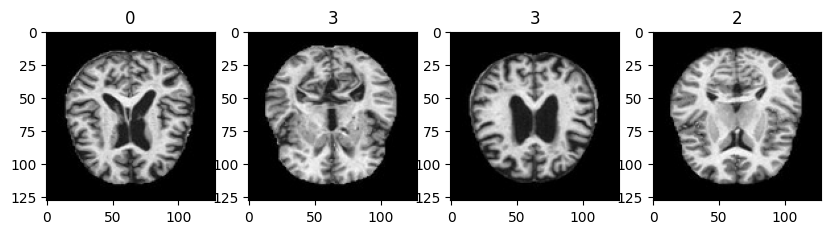

In [12]:
dataset_train = keras. utils.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = (img_width, img_height))

data_iterator = dataset_train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
train_gen = img_generator.flow_from_directory(
        dataset_dir,
        target_size = (64, 64),
        batch_size = batch_size,
        class_mode = None)

Found 6400 images belonging to 4 classes.


In [14]:
#Generator
def generator_model():
    generator = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=latent_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return generator

generator = generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0

In [15]:
#Discriminator
def discriminator_model():
    discriminator = tf.keras.Sequential([
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return discriminator

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)            

In [16]:
class DCGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        # loss metrics
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')


    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        # Train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    
        generated_images = self.generator(random_latent_vectors)
    
        combined_images = tf.concat([generated_images, real_images], axis=0)
    
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))  # Adding noise to labels

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": d_loss, "g_loss": g_loss}


In [17]:
#Monitor and saving images
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128, num_images=10, output_dir='./Dataset/Moderate_Demented'):
        self.latent_dim = latent_dim
        self.num_images = num_images
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_images, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_images):
            img = keras.utils.array_to_img(generated_images[i])
            img_path = os.path.join(self.output_dir, f"generated_img_{epoch:03d}_{i}.png")
            img.save(img_path)

In [18]:
dcgan_monitor = DCGANMonitor(output_dir='./Dataset/Moderate_Demented')

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim)
dcgan.compile(g_optimizer = Adam (learning_rate= 0.0001, beta_1= 0.0001), d_optimizer= Adam (learning_rate = 0.0001 , beta_1= 0.0001), loss_fn = BinaryCrossentropy())

# fit the model and save the history
history = dcgan.fit(train_gen, epochs=epochs, callbacks=[DCGANMonitor()])

Epoch 1/60


2024-10-26 17:53:33.583863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


200/200 [==============================] - 95s 470ms/step - d_loss: 0.3638 - g_loss: 1.3823
Epoch 2/60
200/200 [==============================] - 94s 470ms/step - d_loss: 0.4538 - g_loss: 1.3398
Epoch 3/60
200/200 [==============================] - 100s 503ms/step - d_loss: 0.6218 - g_loss: 1.0031
Epoch 4/60
200/200 [==============================] - 98s 489ms/step - d_loss: 0.6800 - g_loss: 0.8179
Epoch 5/60
200/200 [==============================] - 99s 494ms/step - d_loss: 0.6737 - g_loss: 0.7987
Epoch 6/60
200/200 [==============================] - 99s 495ms/step - d_loss: 0.6782 - g_loss: 0.7972
Epoch 7/60
200/200 [==============================] - 94s 468ms/step - d_loss: 0.6764 - g_loss: 0.7773
Epoch 8/60
200/200 [==============================] - 93s 467ms/step - d_loss: 0.6761 - g_loss: 0.7896
Epoch 9/60
200/200 [==============================] - 93s 465ms/step - d_loss: 0.6705 - g_loss: 0.7906
Epoch 10/60
200/200 [==============================] - 93s 465ms/step - d_loss: 0.6

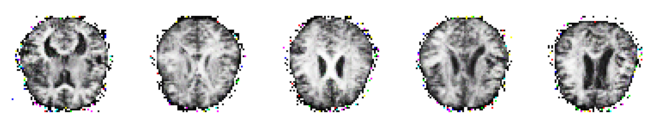

In [19]:
plt.figure(figsize=(10, 10))

for i in range(5):
    plt.subplot(6, 6, i + 1)
    noise = tf.random.normal([1, 128])
    mg = dcgan.generator(noise)
    
    #denormalize
    mg = (mg * 255) + 255
    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

After successfully finishing the data augmentation stage, we chose to randomly choose a number of images loaded with data folders to balance the distribution of labels in the dataset.

In [20]:
#To balance the dataset deleting the images from some folders
def delete_images(label_dir, num_images):
   
    images = os.listdir(label_dir)
    num_images = min(num_images, len(images))

    images_to_delete = random.sample(images, num_images)
    for image in images_to_delete:
        image_path = os.path.join(label_dir, image)
        os.remove(image_path)

non_demented_dir = os.path.join(dataset_dir, "Non_Demented")
very_mild_demented_dir = os.path.join(dataset_dir, "Very_Mild_Demented")

num_delete_nd = 2000
num_delete_vmd = 1000
delete_images(non_demented_dir, num_delete_nd)
delete_images(very_mild_demented_dir, num_delete_vmd)

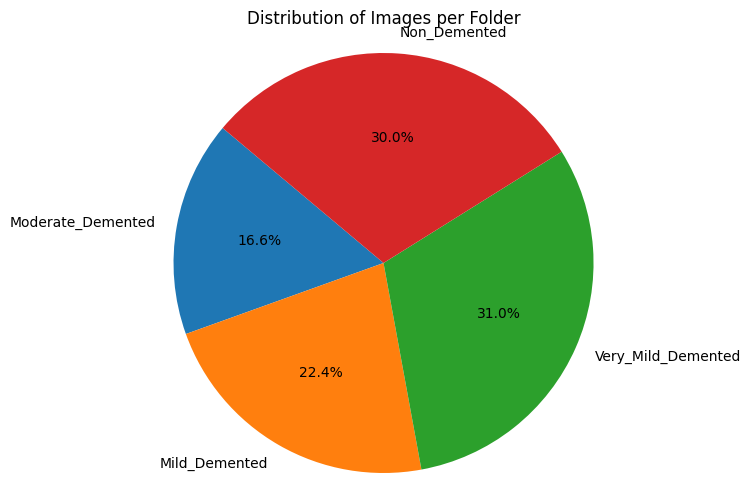

Number of Images in Each Folder:
Moderate_Demented: 664 images
Mild_Demented: 896 images
Very_Mild_Demented: 1240 images
Non_Demented: 1200 images


In [21]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')
plt.show()

print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

As we can see in the piechart, the dataset is not more balanced and ready to be worked with.

### Grey Level Co-occurrence Matrix (GLCM)

In [22]:
#Create dataframe from the dataset
def create_dataframe(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                data.append({'image_path': image_path, 'label': label})
    df = pd.DataFrame(data)
    return df

In [23]:
dataset_dir = "./Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm

,image_path,label
0,./Dataset/Moderate_Demented/generated_img_012_...,Moderate_Demented
1,./Dataset/Moderate_Demented/generated_img_057_...,Moderate_Demented
2,./Dataset/Moderate_Demented/generated_img_034_...,Moderate_Demented
3,./Dataset/Moderate_Demented/generated_img_059_...,Moderate_Demented
4,./Dataset/Moderate_Demented/generated_img_029_...,Moderate_Demented
...,...,...
3995,./Dataset/Non_Demented/non_927.jpg,Non_Demented
3996,./Dataset/Non_Demented/non_1165.jpg,Non_Demented
3997,./Dataset/Non_Demented/non_2493.jpg,Non_Demented
3998,./Dataset/Non_Demented/non_1824.jpg,Non_Demented


In [24]:
#Function for calculate GLCM features
def calculate_glcm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    #properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return contrast, dissimilarity, homogeneity, energy, correlation

In [25]:
def df_with_glcm(df):

    glcm_properties = df['image_path'].apply(calculate_glcm)
    df[['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] = pd.DataFrame(glcm_properties.tolist(), index=df.index)
    return df

dataset_dir = "./Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm = df_with_glcm(df_glcm)
df_glcm

,image_path,label,contrast,dissimilarity,homogeneity,energy,correlation
0,./Dataset/Moderate_Demented/generated_img_012_...,Moderate_Demented,906.267361,17.123016,0.459469,0.436392,0.926908
1,./Dataset/Moderate_Demented/generated_img_057_...,Moderate_Demented,858.342262,16.138889,0.466286,0.426028,0.933479
2,./Dataset/Moderate_Demented/generated_img_034_...,Moderate_Demented,1136.632440,18.259921,0.473981,0.444662,0.916060
3,./Dataset/Moderate_Demented/generated_img_059_...,Moderate_Demented,977.753968,16.105655,0.485166,0.442856,0.936394
4,./Dataset/Moderate_Demented/generated_img_029_...,Moderate_Demented,1294.551587,19.682540,0.459242,0.430825,0.902404
...,...,...,...,...,...,...,...
3995,./Dataset/Non_Demented/non_927.jpg,Non_Demented,336.711245,9.735728,0.458620,0.393100,0.976979
3996,./Dataset/Non_Demented/non_1165.jpg,Non_Demented,398.175074,10.522392,0.456926,0.397136,0.969639
3997,./Dataset/Non_Demented/non_2493.jpg,Non_Demented,312.572096,9.233391,0.467345,0.404286,0.979067
3998,./Dataset/Non_Demented/non_1824.jpg,Non_Demented,324.593504,9.934670,0.449123,0.393315,0.976762


In [26]:
X = df_glcm.iloc[:,2:7]
y = df_glcm['label']

X

,contrast,dissimilarity,homogeneity,energy,correlation
0,906.267361,17.123016,0.459469,0.436392,0.926908
1,858.342262,16.138889,0.466286,0.426028,0.933479
2,1136.632440,18.259921,0.473981,0.444662,0.916060
3,977.753968,16.105655,0.485166,0.442856,0.936394
4,1294.551587,19.682540,0.459242,0.430825,0.902404
...,...,...,...,...,...
3995,336.711245,9.735728,0.458620,0.393100,0.976979
3996,398.175074,10.522392,0.456926,0.397136,0.969639
3997,312.572096,9.233391,0.467345,0.404286,0.979067
3998,324.593504,9.934670,0.449123,0.393315,0.976762


In [27]:
#Machine Learning function
def ml_models(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time

# Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    accuracy = classification_report(y_test, y_pred)
    print("classification_report:", accuracy)

    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Prediction Time: {predict_time:.4f} seconds")

# Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix')
    plt.show()

Accuracy: 0.65
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.56      0.58      0.57       189
 Moderate_Demented       0.99      0.91      0.95       147
      Non_Demented       0.65      0.69      0.67       218
Very_Mild_Demented       0.53      0.51      0.52       246

          accuracy                           0.65       800
         macro avg       0.68      0.67      0.68       800
      weighted avg       0.65      0.65      0.65       800

Training Time: 0.9526 seconds
Prediction Time: 0.0297 seconds


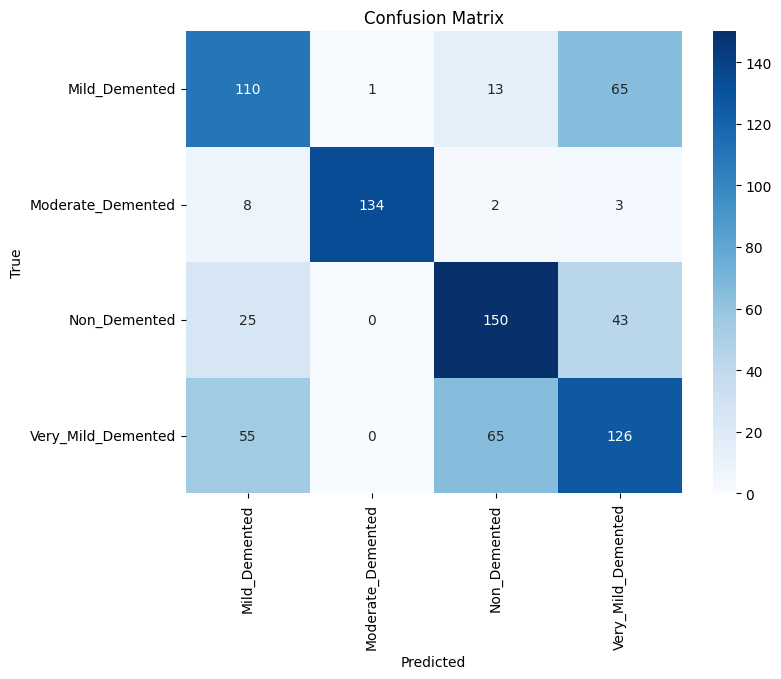

In [28]:
#RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=300)
ml_models(rf_model, X, y)

Accuracy: 0.51375
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.37      0.59      0.46       189
 Moderate_Demented       0.99      0.90      0.95       147
      Non_Demented       0.47      0.73      0.57       218
Very_Mild_Demented       0.25      0.03      0.05       246

          accuracy                           0.51       800
         macro avg       0.52      0.56      0.51       800
      weighted avg       0.48      0.51      0.45       800

Training Time: 0.0023 seconds
Prediction Time: 0.0004 seconds


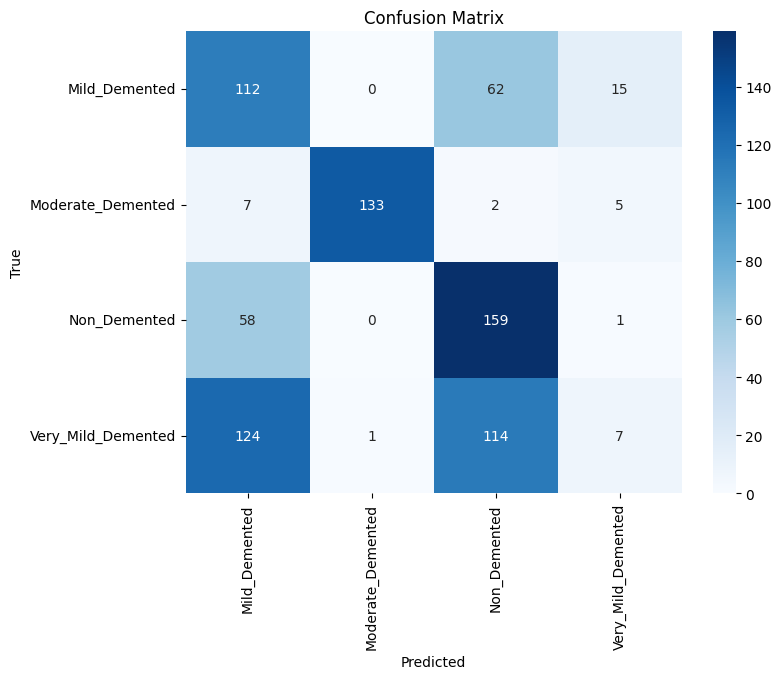

In [29]:
#GAUSSIAN NB
gnb_model = GaussianNB()
ml_models(gnb_model, X, y)

Accuracy: 0.5775
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.54      0.50      0.52       189
 Moderate_Demented       0.96      0.89      0.92       147
      Non_Demented       0.52      0.56      0.54       218
Very_Mild_Demented       0.45      0.47      0.46       246

          accuracy                           0.58       800
         macro avg       0.62      0.60      0.61       800
      weighted avg       0.58      0.58      0.58       800

Training Time: 0.0127 seconds
Prediction Time: 0.0004 seconds


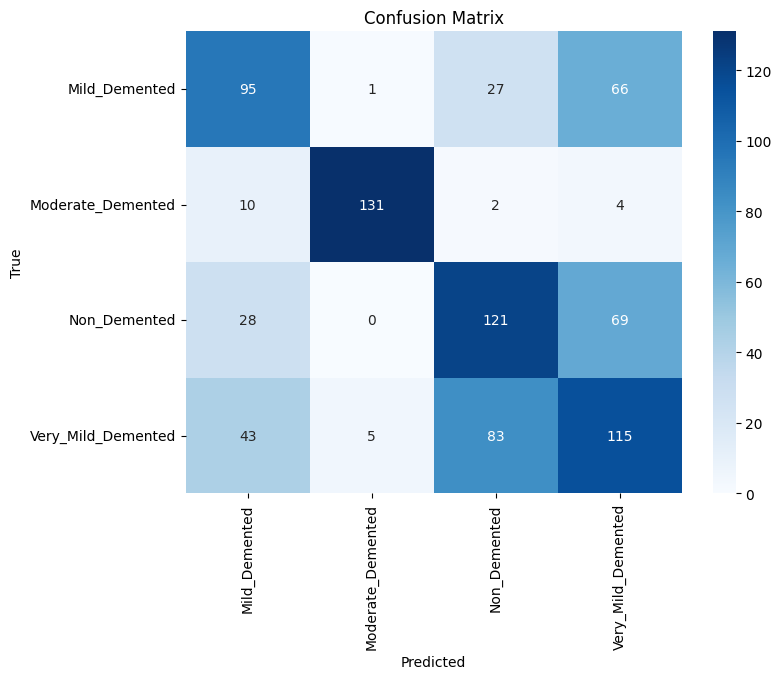

In [30]:
#DECISION TREE
dt_model = DecisionTreeClassifier()
ml_models(dt_model, X, y)

Accuracy: 0.51375
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.50      0.01      0.01       189
 Moderate_Demented       1.00      0.90      0.95       147
      Non_Demented       0.46      0.52      0.49       218
Very_Mild_Demented       0.39      0.67      0.50       246

          accuracy                           0.51       800
         macro avg       0.59      0.52      0.48       800
      weighted avg       0.55      0.51      0.46       800

Training Time: 5.4399 seconds
Prediction Time: 0.0220 seconds


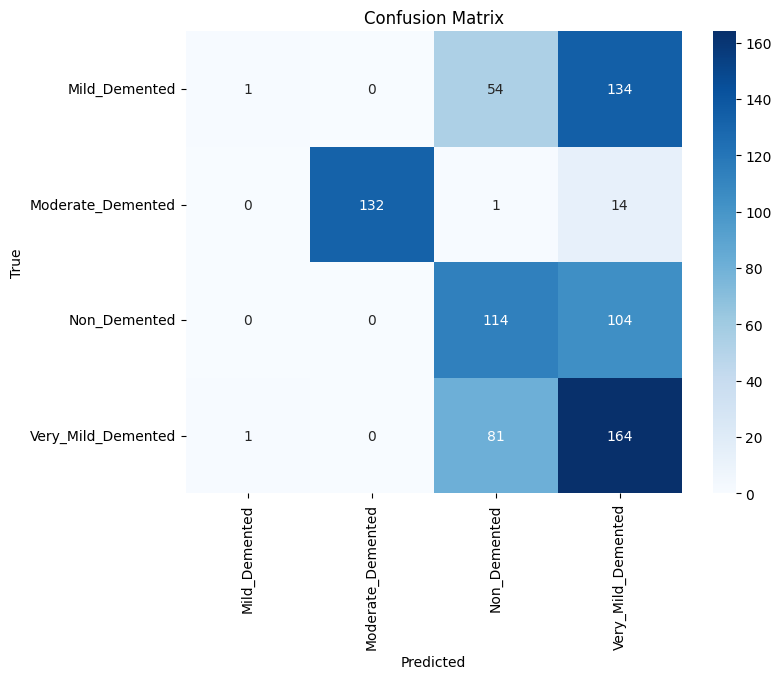

In [31]:
#SVM
svm_model = SVC(kernel='linear', random_state=42)
ml_models(svm_model, X, y)

Accuracy: 0.51625
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.38      0.08      0.13       189
 Moderate_Demented       0.99      0.88      0.94       147
      Non_Demented       0.45      0.57      0.50       218
Very_Mild_Demented       0.41      0.59      0.48       246

          accuracy                           0.52       800
         macro avg       0.56      0.53      0.51       800
      weighted avg       0.52      0.52      0.49       800

Training Time: 0.1631 seconds
Prediction Time: 0.0006 seconds


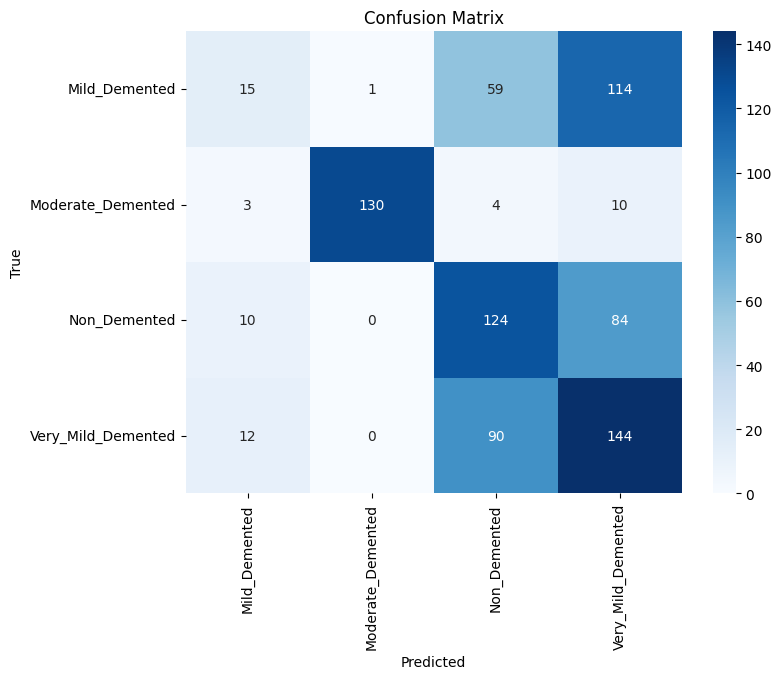

In [32]:
#LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ml_models(lr_model, X, y)

In [33]:
def get_images(directory):
    Images = []
    Labels = []
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

In [34]:
#Train data
Images, Labels = get_images("./Dataset/") #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [35]:
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(Labels)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

In [37]:
from collections import Counter
Counter(encoded_labels)

Counter({3: 1240, 2: 1200, 0: 896, 1: 664})

### Deep Learning

In [38]:
#Function for deep learning approaches
def deep_learning(base_model, input_shape=(128, 128, 3), num_classes=4):
    model = Sequential()
    model.add(base_model(include_top=False, weights='imagenet', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [39]:
#EfficientNetB0
efficientnet_model = deep_learning(EfficientNetB0)
efficientnet_model.summary()

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
start_time_effnet = time.time()
training_history_eff = efficientnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)
train_time_effnet = time.time() - start_time_effnet

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              83890176  
                                                                 
 dense_3 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 dense_6 (Dense)             (None, 32)               

Epoch 1/100
100/100 [==============================] - 30s 280ms/step - loss: 0.9661 - accuracy: 0.5234 - val_loss: 0.9369 - val_accuracy: 0.5512
Epoch 2/100
100/100 [==============================] - 27s 266ms/step - loss: 0.8621 - accuracy: 0.5938 - val_loss: 0.8597 - val_accuracy: 0.6075
Epoch 3/100
100/100 [==============================] - 27s 264ms/step - loss: 0.8083 - accuracy: 0.6184 - val_loss: 0.8016 - val_accuracy: 0.6413
Epoch 4/100
100/100 [==============================] - 27s 270ms/step - loss: 0.7701 - accuracy: 0.6356 - val_loss: 0.8432 - val_accuracy: 0.6175
Epoch 5/100
100/100 [==============================] - 27s 267ms/step - loss: 0.7277 - accuracy: 0.6697 - val_loss: 0.6944 - val_accuracy: 0.6662
Epoch 6/100
100/100 [==============================] - 26s 261ms/step - loss: 0.6429 - accuracy: 0.7131 - val_loss: 0.6695 - val_accuracy: 0.7100
Epoch 7/100
100/100 [==============================] - 26s 260ms/step - loss: 0.6209 - accuracy: 0.7287 - val_loss: 0.7281 -

25/25 [==============================] - 5s 130ms/step
F1 Score: 0.9145841644034924
Recall: 0.915
Precision: 0.9183052770807711
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       151
           1       0.98      1.00      0.99       132
           2       0.96      0.83      0.89       260
           3       0.86      0.92      0.89       257

    accuracy                           0.92       800
   macro avg       0.92      0.93      0.93       800
weighted avg       0.92      0.92      0.91       800

Training Time: 2592.7622559070587
Prediction Time: 4.583129167556763


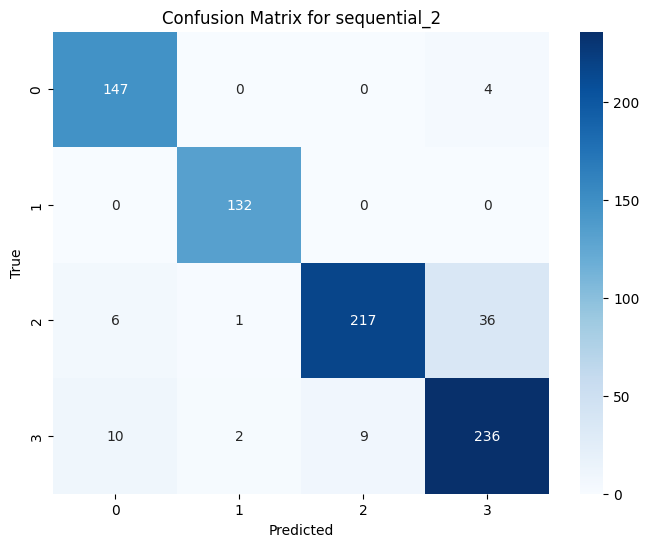

In [50]:
start_time_effnet = time.time()
y_pred = np.argmax(efficientnet_model.predict(X_test), axis=1)
predict_time_effnet = time.time() - start_time_effnet

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_effnet)
print("Prediction Time:", predict_time_effnet)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {efficientnet_model.name}')
plt.show()

In [41]:
#VGG16
vgg_model = deep_learning(VGG16)
vgg_model.summary()

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
start_time_vgg = time.time()
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)
train_time_vgg = time.time() - start_time_vgg

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_9 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 32)               

Epoch 1/100
100/100 [==============================] - 114s 1s/step - loss: 1.2096 - accuracy: 0.5525 - val_loss: 0.8192 - val_accuracy: 0.6450
Epoch 2/100
100/100 [==============================] - 111s 1s/step - loss: 0.7047 - accuracy: 0.6913 - val_loss: 0.7366 - val_accuracy: 0.7050
Epoch 3/100
100/100 [==============================] - 110s 1s/step - loss: 0.4969 - accuracy: 0.7969 - val_loss: 0.7249 - val_accuracy: 0.7088
Epoch 4/100
100/100 [==============================] - 110s 1s/step - loss: 0.4653 - accuracy: 0.8188 - val_loss: 0.5290 - val_accuracy: 0.8075
Epoch 5/100
100/100 [==============================] - 111s 1s/step - loss: 0.3551 - accuracy: 0.8606 - val_loss: 0.5286 - val_accuracy: 0.7850
Epoch 6/100
100/100 [==============================] - 112s 1s/step - loss: 0.1865 - accuracy: 0.9350 - val_loss: 0.5340 - val_accuracy: 0.8037
Epoch 7/100
100/100 [==============================] - 109s 1s/step - loss: 0.1046 - accuracy: 0.9691 - val_loss: 0.4668 - val_accuracy:

25/25 [==============================] - 22s 880ms/step
F1 Score: 0.8955862302449051
Recall: 0.89625
Precision: 0.8986197178765
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       151
           1       1.00      0.97      0.98       132
           2       0.91      0.80      0.85       260
           3       0.84      0.90      0.87       257

    accuracy                           0.90       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.90      0.90      0.90       800

Training Time: 11402.117743968964
Prediction Time: 22.090152978897095


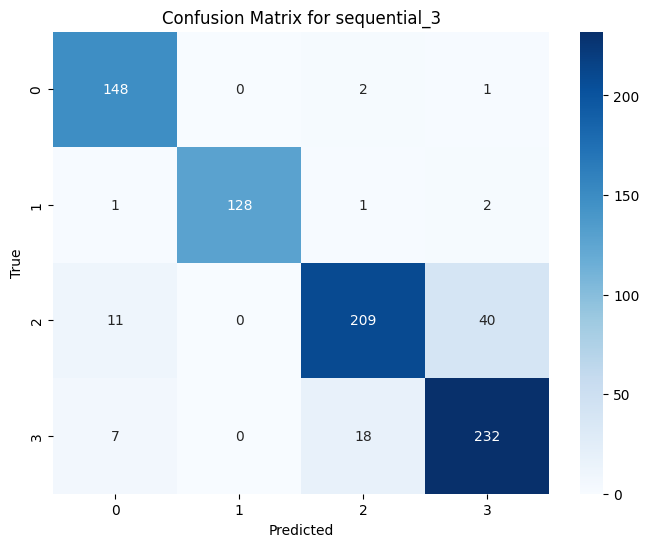

In [42]:
start_time_vgg = time.time()
y_pred = np.argmax(vgg_model.predict(X_test), axis=1)
predict_time_vgg = time.time() - start_time_vgg

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_vgg)
print("Prediction Time:", predict_time_vgg)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {vgg_model.name}')
plt.show()

In [43]:
#ResNet50
resnet_model = deep_learning(ResNet50)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
start_time_resnet = time.time()
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)
train_time_resnet = time.time() - start_time_resnet

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_14 (Dense)            (None, 4096)              134221824 
                                                                 
 dense_15 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_16 (Dense)            (None, 256)               262400    
                                                                 
 dense_17 (Dense)            (None, 64)                16448     
                                                                 
 dense_18 (Dense)            (None, 32)               

Epoch 1/100
100/100 [==============================] - 77s 756ms/step - loss: 1.1311 - accuracy: 0.5362 - val_loss: 0.8144 - val_accuracy: 0.6475
Epoch 2/100
100/100 [==============================] - 69s 692ms/step - loss: 0.7449 - accuracy: 0.6684 - val_loss: 0.7641 - val_accuracy: 0.6575
Epoch 3/100
100/100 [==============================] - 62s 621ms/step - loss: 0.6293 - accuracy: 0.7244 - val_loss: 0.8127 - val_accuracy: 0.6438
Epoch 4/100
100/100 [==============================] - 76s 764ms/step - loss: 0.4866 - accuracy: 0.8056 - val_loss: 0.6026 - val_accuracy: 0.7550
Epoch 5/100
100/100 [==============================] - 78s 779ms/step - loss: 0.4038 - accuracy: 0.8422 - val_loss: 0.7435 - val_accuracy: 0.6787
Epoch 6/100
100/100 [==============================] - 71s 710ms/step - loss: 0.3291 - accuracy: 0.8813 - val_loss: 0.6837 - val_accuracy: 0.7350
Epoch 7/100
100/100 [==============================] - 73s 726ms/step - loss: 0.2427 - accuracy: 0.9094 - val_loss: 0.6994 -

25/25 [==============================] - 9s 340ms/step
F1 Score: 0.8714026188652879
Recall: 0.87125
Precision: 0.8724376600193205
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       151
           1       1.00      0.98      0.99       132
           2       0.87      0.82      0.85       260
           3       0.82      0.85      0.84       257

    accuracy                           0.87       800
   macro avg       0.88      0.89      0.89       800
weighted avg       0.87      0.87      0.87       800

Training Time: 7753.593512296677
Prediction Time: 8.935564756393433


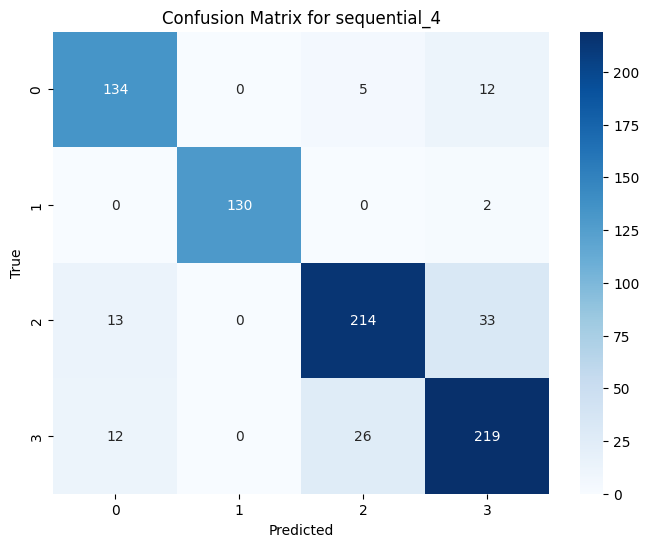

In [44]:
start_time_resnet = time.time()
y_pred = np.argmax(resnet_model.predict(X_test), axis=1)
predict_time_resnet = time.time() - start_time_resnet

f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Training Time:", train_time_resnet)
print("Prediction Time:", predict_time_resnet)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {resnet_model.name}')
plt.show()

In [45]:
training_histories = {
    'VGG16': training_history_vgg,
    'ResNet50': training_history_resnet,
    'EfficientNetB0': training_history_eff
}

In [46]:
def plot_training_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 8))
    
    for model, history in histories.items():
        plt.plot(history.history[metric], label=f'{model} Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'{model} Validation {metric.capitalize()}')

    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

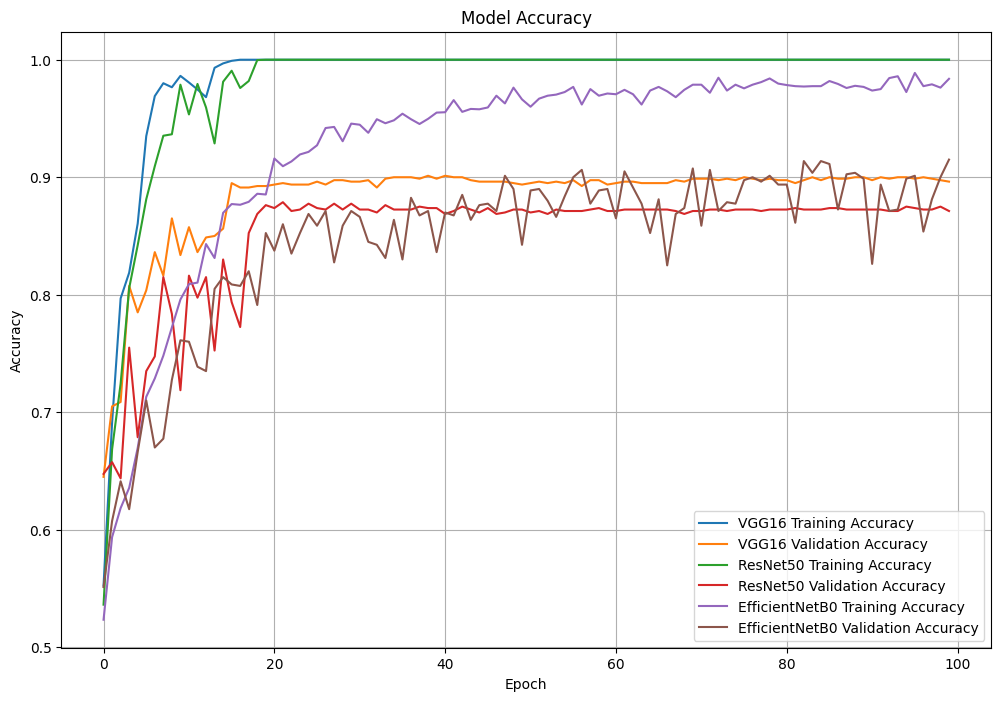

In [47]:
plot_training_history(training_histories, metric='accuracy')

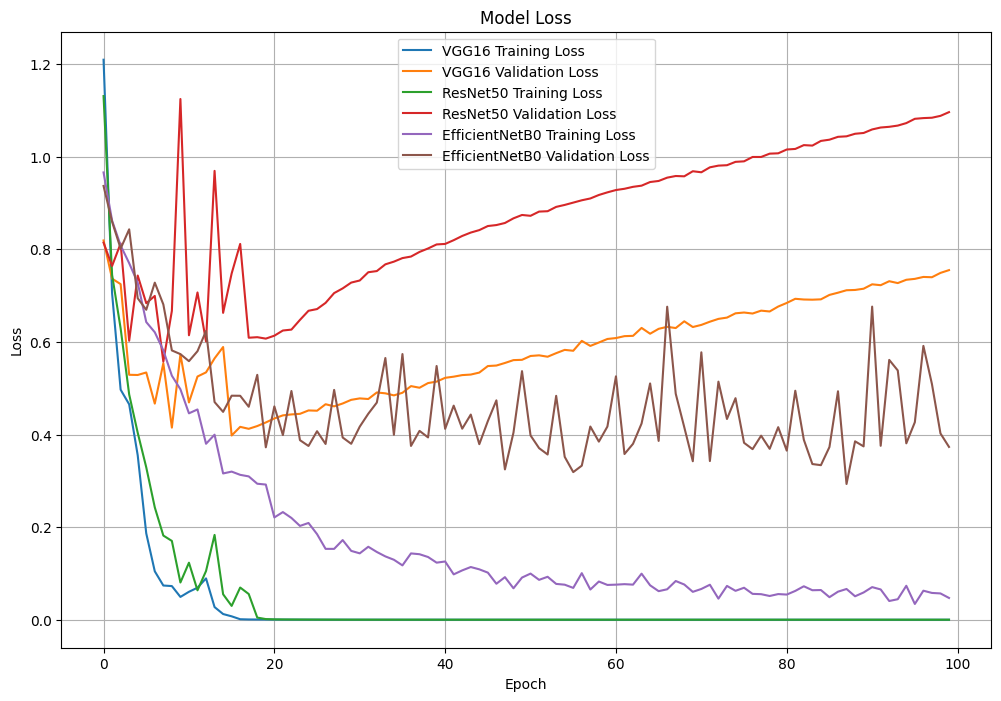

In [48]:
plot_training_history(training_histories, metric='loss')

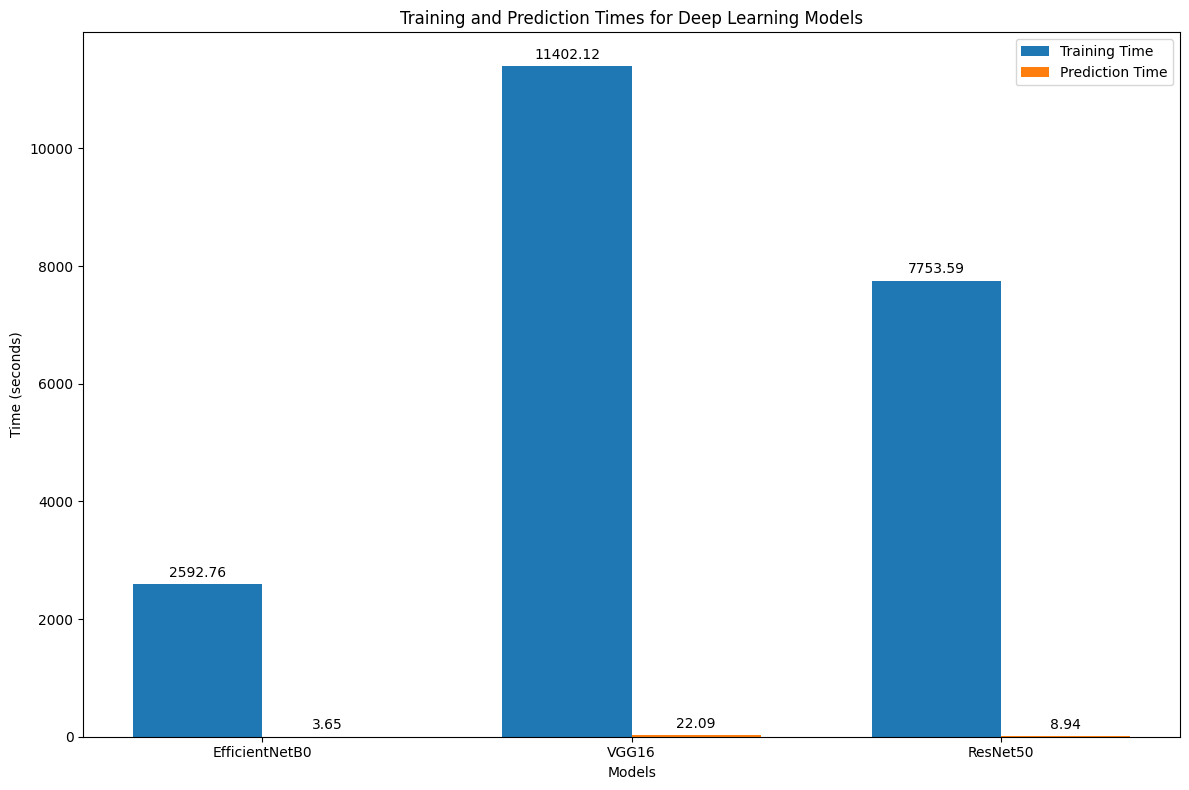

In [49]:
dl_models_names = ['EfficientNetB0', 'VGG16', 'ResNet50']
train_times = [train_time_effnet, train_time_vgg, train_time_resnet]
predict_times = [predict_time_effnet, predict_time_vgg, predict_time_resnet]

x = np.arange(len(dl_models_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width/2, train_times, width, label='Training Time')
rects2 = ax.bar(x + width/2, predict_times, width, label='Prediction Time')

ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Prediction Times for Deep Learning Models')
ax.set_xticks(x)
ax.set_xticklabels(dl_models_names)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()